#**Gradient Ascent: Learning an Image that Maximizes a Given Filter's Activation**

First, we load our trained CNN...

In [1]:
from tensorflow import keras
import numpy as np
from google.colab import drive

model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Next, we load an image to feed through the model...

195468/195468 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


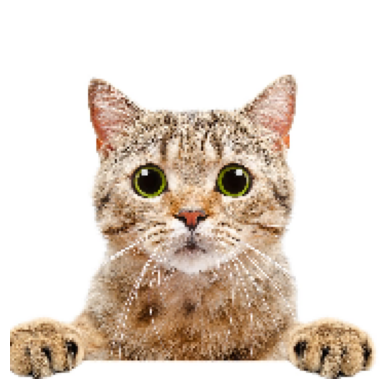

In [5]:
img_path = keras.utils.get_file(
    fname="cat10.jpg",
    origin="https://i.guim.co.uk/img/media/26392d05302e02f7bf4eb143bb84c8097d09144b/446_167_3683_2210/master/3683.jpg?width=1200&height=1200&quality=85&auto=format&fit=crop&s=49ed3252c0b2ffb49cf8b508892e452d")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0) # add a dimension to the tensor (reflecting 'batch size' which my network will expect to receive as input)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

We extract all the layer names from Xception...

In [6]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


In [7]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

Here, feature_extractor is a built-in function from the Keras library.

In [8]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

We are defining a function that computes the average relationship between a given layer-filter's output and the image input. So, if a filter is

In [9]:
from keras import ops

def compute_average_activation(image, filter_index):
    featuremaps = feature_extractor(image)
    # For a particular filter in the layer, we obtain the activations for that particular filter and then average them.
    filter_activation = featuremaps[:, :, :, filter_index]
    return ops.mean(filter_activation)

Now we will use gradient tape to calculate how activation of this filter relates to image input. Here, tape.watch() is an alternative to declaring the tensorflow variable.

In [10]:
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        activation = compute_average_activation(image, filter_index)
    grads = tape.gradient(activation, image)
    grads = ops.normalize(grads)
    image += learning_rate * grads
    return image

Now we will update our *image* pixel values, starting with a random image, trying to set pixel values that maximize activating a particular feature! We will start with static and then update the pixel values 30 terms.

In [11]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = keras.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0]

Now that we have 'learned' the image that optimizes activating a certain filter, let's make it into something we can visualize.

In [17]:
def make_image(image):
    image += -1*np.min(image) # Shift the resulting pixel values to be starting from 0
    image /= np.max(image) # Scale by the maximum
    image *= 255 # Multiply by 255 to get meaningful pixel values.
    image = ops.cast(image, dtype="uint8")
    return ops.convert_to_numpy(image)

Now we can visualize our image...

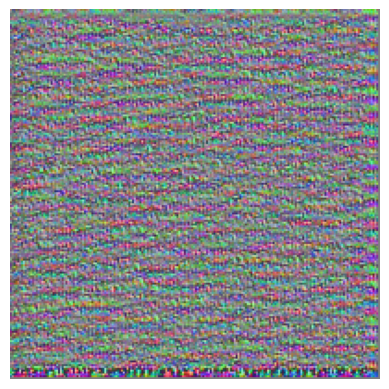

In [18]:
plt.axis("off")
filter_pattern = generate_filter_pattern(filter_index=2)
image = make_image(filter_pattern)
plt.imshow(image)
plt.show()

And we can do the same thing for lots of filters!

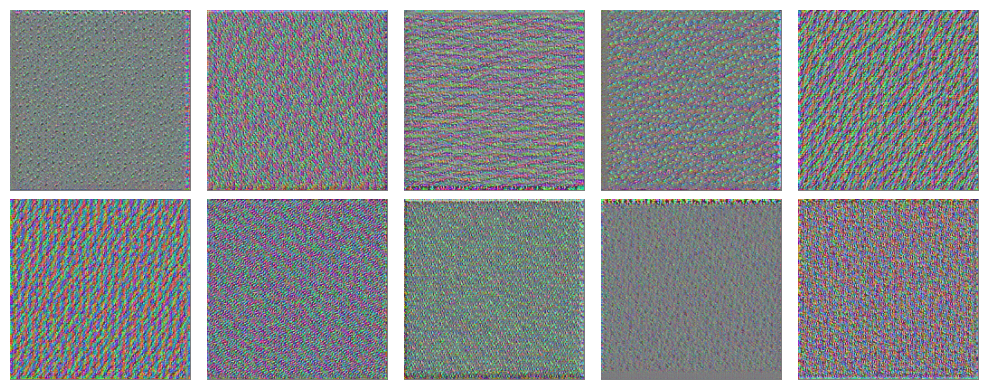

In [23]:
import matplotlib.pyplot as plt

all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = make_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

# Create a figure with 10 subplots arranged in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Loop over the first 10 images in all_images
for i, image in enumerate(all_images[:10]):
    # Get the subplot for the current image
    row = i // 5  # Calculate the row index
    col = i % 5   # Calculate the column index
    ax = axes[row, col]

    # Display the image in the subplot
    ax.imshow(image)
    ax.axis("off")  # Turn off axis labels

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()